# Introduction

In order to successful knowledge discovery in databases (KDD), well-defined and formal methods should be applied for managing data.  Cross-industry standard process for data mining (CRISP-DM) model is a standard methodology, which includes six phases:
    1. Problem domain understanding
    2. Data Understanding
    3. Data Preparation
    4. Modeling
    5. Evaluation
    6. Deployment

----------------------------------------------------------------------------------------------------------------------

# Part 1 - Problem domain understanding

----------------------------------------------------------------------------------------------------------------------

# Part 2 - Data Exploration & Understanding

http://localhost:8888/notebooks/0-MyCollection/00-Sample/01-DataExploration.ipynb

## 1. Import Library and Define Common function

### 1.1. Import Library

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pylab
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set(style = 'whitegrid',context = 'notebook')

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

# Modelling Helpers:
# from sklearn.preprocessing import Imputer, Normalizer, scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, ShuffleSplit, cross_validate
from sklearn import model_selection
from sklearn.model_selection import train_test_split

# Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
# Evaluation metrics for Classification
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import mutual_info_score

# Regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,ElasticNet,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
# Evaluation metrics for Regression 
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, roc_auc_score, auc,
                             precision_score, recall_score, roc_curve, precision_recall_curve,
                             precision_recall_fscore_support, f1_score,
                             precision_recall_fscore_support)

# Configuration
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


# Supress warnings
import warnings
warnings.filterwarnings("ignore")

print("Setup complete...")

C:\Users\maint\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Setup complete...


### 1.2. Common Function

In [2]:
# Distribution plot

def analyse_continuous(df,var,target):
    df = df.copy()
    # df[var] = df[var].fillna(df[var].median())
    plt.figure(figsize=(20,5))
       
    # histogram
    plt.subplot(131)
    sns.distplot(df[var], bins=30)
    #sns.distplot(df[var],hist=True, kde=True,kde_kws={'shade': True, 'linewidth': 3})
    plt.title('Histogram')    
    
    # Q-Q plot
    plt.subplot(132)
    stats.probplot(df[var], dist="norm", plot=pylab)
    plt.ylabel('Quantiles')    
    
    # boxplot
    plt.subplot(133)
    sns.boxplot(x=df[var])
    plt.title('Boxplot')
          
    # skewness and kurtosis
    print('Skewness: %f' % df[var].skew())
    print('Kurtosis: %f' % df[var].kurt())
    plt.show()

In [3]:
def Training_Preparation(df, cont_vars):
    num_df = df[cont_vars].copy()

    # scaling features
    from sklearn.preprocessing import MinMaxScaler
    numdf_norm = pd.DataFrame(MinMaxScaler().fit_transform(df[cont_vars]))
    numdf_norm.columns = num_df.columns
    
    # Define X & y
    X = numdf_norm
    y = df['Class']

    # Split to train and test set
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=90, stratify = y)
    
    # initialize models
    models = []
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVC', SVC(kernel="linear")))
    models.append(('LSVC', SVC(kernel="rbf")))
    models.append(('LR', LogisticRegression()))
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('GNB', GaussianNB()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('GB', GradientBoostingClassifier()))
    models.append(('LGB',LGBMClassifier()))
    models.append(('ADA',AdaBoostClassifier()))
    models.append(('LDA',LinearDiscriminantAnalysis()))
    models.append(('QDA',QuadraticDiscriminantAnalysis()))
    models.append(('NN',MLPClassifier()))
    models.append(('XGB',XGBClassifier()))
    
    # Test options and evaluation metric
    seed = 9
    scoring = 'recall_macro'

    # evaluate each model in turn
    results = {}
    names = []

    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state = seed)
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results[name] = cv_results
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    results_df = pd.DataFrame(results)
    plt.figure(figsize=(16,8))
    sns.boxplot(data=results_df)
    plt.show()

In [4]:
from matplotlib.backends.backend_pdf import PdfPages


def DistributionComparison(all_df, selected_vars,name):
    colors = ['#3791D7','#D72626']

    # pdf = matplotlib.backends.backend_pdf.PdfPages(name + '.pdf')
    with PdfPages(name + '.pdf') as pdf_pages:
        for column in selected_vars:    
            fig = plt.figure(figsize=[8,4])
            plt.subplot(121)
            sns.boxplot(x='Class', y=column,data=all_df,palette=colors)
            plt.title(column, fontsize=12)
            plt.subplot(122)
            sns.kdeplot(all_df[all_df.Class==1][column], bw = 0.4, label = "Cancer", shade=True, color="#D72626", linestyle="--")
            sns.kdeplot(all_df[all_df.Class==0][column], bw = 0.4, label = "NoCancer", shade=True, color= "#3791D7", linestyle=":")
            plt.title(column, fontsize=12)   
            pdf_pages.savefig(fig)                                          
            plt.show()    

    # Write the PDF document to the disk
    #pdf_pages.close()

In [5]:
def ModelEvaluation(df, cont_vars):
    
    num_df = df[cont_vars].copy()

    # scaling features
    from sklearn.preprocessing import MinMaxScaler
    numdf_norm = pd.DataFrame(MinMaxScaler().fit_transform(df[cont_vars]))
    numdf_norm.columns = num_df.columns
    
    # Define X & y
    X = numdf_norm
    y = df['Class']

    # Split to train and test set
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=90, stratify = y)
    
    # initialize models
    models = []
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVC', SVC(kernel="linear")))
    models.append(('LSVC', SVC(kernel="rbf")))
    models.append(('LR', LogisticRegression()))
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('GNB', GaussianNB()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('GB', GradientBoostingClassifier()))
    models.append(('LGB',LGBMClassifier()))
    models.append(('ADA',AdaBoostClassifier()))
    models.append(('LDA',LinearDiscriminantAnalysis()))
    models.append(('QDA',QuadraticDiscriminantAnalysis()))
    models.append(('NN',MLPClassifier()))
    models.append(('XGB',XGBClassifier()))
    
    for name,model in models:
        print(name)
        model.fit(X_train, y_train)
        
        print('==========================================================')
        print('Train set')
        y_train_pred = model.predict(X_train)
        print('Accuracy: ', accuracy_score(y_train, list(y_train_pred)))
        print('ROC AUC Score: ', roc_auc_score(y_train, list(y_train_pred)))
        cm_df = pd.DataFrame(confusion_matrix(y_train,list(y_train_pred)), index=model.classes_,columns=model.classes_)
        cm_df.index.name = 'True'
        cm_df.columns.name = 'Predicted'
        print('Confusion matrix')
        print(cm_df)
        print(classification_report(y_train, list(y_train_pred)))
  
        print('----------------------------------------------------------')
        print('Test set')
        y_test_pred = model.predict(X_test)
        print('Accuracy: ', accuracy_score(y_test, list(y_test_pred)))
        print('ROC AUC Score: ', roc_auc_score(y_test, list(y_test_pred)))
        cm_df = pd.DataFrame(confusion_matrix(y_test,list(y_test_pred)), index=model.classes_,columns=model.classes_)
        cm_df.index.name = 'True'
        cm_df.columns.name = 'Predicted'
        print('Confusion matrix')
        print(cm_df)
        print(classification_report(y_test, list(y_test_pred)))
        print('==========================================================')
        

In [6]:
from sklearn.manifold import TSNE

def tsne_plot(X, y):
       
        
    # scaling features
    from sklearn.preprocessing import MinMaxScaler
    numdf_norm = pd.DataFrame(MinMaxScaler().fit_transform(X))
    numdf_norm.columns = X.columns
    
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(numdf_norm)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y == 0), 0], X_t[np.where(y == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='No cancer')
    plt.scatter(X_t[np.where(y == 1), 0], X_t[np.where(y == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Colon cancer')

    plt.legend(loc='best');
    plt.show();

In [7]:
# function to find upper and lower boundaries
# for normally distributed variables

def find_normal_boundaries(df, variable):

    # calculate the boundaries outside which sit the outliers
    # for a Gaussian distribution

    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

In [8]:
# function to find upper and lower boundaries
# for skewed distributed variables

def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [9]:
def find_uncorrelated_vars(cancer_df, selected_vars, threshold):

    corrmat = cancer_df[selected_vars].corr()
    corrmat = corrmat.abs().unstack() # absolute value of corr coef
    corrmat = corrmat.sort_values(ascending=False)

    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
    corrmat['MissingF1'] = corrmat.feature1.apply(lambda x:MissingPercentage(x))
    corrmat['MissingF2'] = corrmat.feature2.apply(lambda x:MissingPercentage(x))
    
    correlated_groups = corrmat[corrmat['corr'] > threshold]
    
    selected_vars = []
    remaining_vars = correlated_groups.feature1.unique()

    while(len(remaining_vars) > 0):
        feature = remaining_vars[0]
        correlated_block = correlated_groups[correlated_groups.feature1 == feature]
        min_ind = correlated_block[['MissingF2']].idxmin() 
        sel_var = correlated_block.feature2[min_ind].values[0]
        removed_vars = [var for var in list(correlated_block.feature2.values)]
        remaining_vars = [var for var in remaining_vars if var not in removed_vars]
        if sel_var not in selected_vars:
            selected_vars = selected_vars + [sel_var]   
    
    return selected_vars

In [10]:
def analyze_na_values(df, var, target):
    tmp_df = df.copy()
    print(target)
    
    # Make a variable that indicates 1 if the observation was missing or 0 otherwise
    tmp_df['Missing'] = np.where(df[var].isnull(),1,0)
    
    # Calculate the mean Price where the information is missing or present
    tmp_df =  pd.DataFrame(tmp_df.groupby([target,'Missing'])[target].count())
    tmp_df.columns = ['Count']
    tmp_df = tmp_df.reset_index()
    
    
    if(len(tmp_df[tmp_df[target] == 0] == 1)):
        tmp_df= tmp_df.append({target:0,'Missing':1,'Count':0}, ignore_index=True)

    if(len(tmp_df[tmp_df[target] == 1] == 1)):
        tmp_df= tmp_df.append({target:1,'Missing':1,'Count':0}, ignore_index=True)

    tmp_df.loc[0,'Per']= tmp_df.loc[0,'Count']/(tmp_df.loc[0:1,'Count'].sum())
    tmp_df.loc[1,'Per']= tmp_df.loc[1,'Count']/(tmp_df.loc[0:1,'Count'].sum())
    tmp_df.loc[2,'Per']= tmp_df.loc[2,'Count']/(tmp_df.loc[2:3,'Count'].sum())
    tmp_df.loc[3,'Per']= tmp_df.loc[3,'Count']/(tmp_df.loc[2:3,'Count'].sum())
    sns.barplot(x=target, y = 'Per', data=tmp_df, hue='Missing')
    plt.title(var)
    plt.show()

In [11]:
def CategoricalDistribution(df, var, target):
    df = df.copy()
    
    # Calculate the mean Price where the information is missing or present
    sns.countplot(x=var, data=df, hue=target)
    plt.title(var)
    plt.show()

In [12]:
def CreateDummyVar(df, categorical_list):
    objdf_new = df.copy()
    objdf_dummy =pd.DataFrame()
    i = 0
    for e in categorical_list:
        i = i + 1
        objdf_new[e] = e + '_' + objdf_new[e].astype(str)
        varname= e 
        df_temp = pd.get_dummies(objdf_new[varname], drop_first=True)
        objdf_dummy = pd.concat([objdf_dummy, df_temp], axis=1)
        
    return objdf_dummy

In [13]:
def MissingPercentage(x):
    return df[x].isnull().sum()/len(df)

## 2. Load raw data

In [124]:
df = pd.read_csv('Nhanes-BreastCancer_merged.csv')
org_df = df.copy()

print(df.shape)
df.head()

(1173, 461)


,RIDAGEYR,RIDAGEMN,INDFMPIR,LBXSAL,LBDSGLSI,URDTIME2,LBDSBUSI,LBDHDDSI,LBDLYMNO,LBXSCA,URXMBP,LBDSCASI,URXMZP,URDFLOW2,LBXGLU,LBXBGE,LBXBPB,LBDBCDSI,URXUMS,LBXSGL,LBXSOSSI,LBXIHG,URXMHH,URXVOL3,URXMHP,URDTIME1,LBXSZN,LBXSKSI,LBDTHGSI,URXMIB,URDFLOW3,URXMNP,LBXBCD,LBXSATSI,LBXSBU,LBDSTRSI,LBDSCRSI,LBXSUA,LBDSTPSI,LBXSTR,URXVOL1,LBXLYPCT,URXVOL2,LBDSTBSI,URXECP,LBDTCSI,LBXNEPCT,LBXBGM,LBXHGB,LBXSTP,URXCNP,LBXPLTSI,LBDIHGSI,LBDSIRSI,LBXSGTSI,LBXBAPCT,LBXSTB,LBXMCHSI,LBDNENO,LBXSCR,LBDSZNSI,LBXMOPCT,LBXMPSI,LBXSIR,PHAANTMN,LBDSCUSI,PHAALCMN,LBXRBCSI,URXUIO,LBDSUASI,LBDSPHSI,URXCRS,URXMEP,LBXMCVSI,LBXSCH,URXMC1,LBXGLT,WTSVS2YR,LBXSLDSI,LBXRDW,WTFSM,PHAGUMMN,LBXSGB,LBDBPBSI,LBDGLTSI,WTSVOC2Y,URXCOP,LBDGLUSI,LBXSCU,LBXSSE,LBXWBCSI,LBDHDD,LBDSSESI,URDFLOW1,LBXSPH,PHACOFMN,PHASUPMN,WTSOG2YR,URXUMA,LBXSASSI,LBXEOPCT,LBDSGBSI,LBXSAPSI,LBXTC,LBXMC,URDTIME3,LBXTHG,LBDSCHSI,URXMOH,LBDMONO,LBDEONO,LBDBANO,LBDSALSI,PHASUPHR,LBXSCLSI,LBXSNASI,PHAGUMHR,PHAANTHR,PHACOFHR,PHAALCHR,LBXSC3SI,DXDLAPF,DXDTRBMD,DXDSTBMC,DXXTRFAT,DXXHEFAT,DXDSTLE,DXXRALI,DXDTOFAT,DXDTOBMD,DXXLSBMC,DXXTRLI,DXDRATOT,BPXDI3,DXXHEA,DXDTOPF,DXDRLTOT,DXDTRPF,DXXLLBMD,DXXRLLI,BMXARMC,DXDRALE,DXXLLBMC,DXXLALI,DXXLRBMC,DXXPEA,DXDRAPF,BPXDI1,DXXPEBMD,DXDTRTOT,DXXRAA,DXDLLPF,BMXARML,DXXHELI,DXXRRA,DXDSTBMD,BPXDI4,DXXLLLI,DXDRLPF,BPXDI2,DXXLSBMD,BPXPLS,DXDTOBMC,DXDTOLE,DXXLRBMD,DXDTRLE,DXXHEBMC,DXDSTTOT,DXXRLA,BMXLEG,BPXSY1,DXXLAA,DXXLABMC,DXDLALE,DXDTRA,BMXWT,DXXTSBMC,DXXLLA,DXXLLFAT,DXDTOLI,BMXHT,DXXLABMD,DXDSTLI,DXXRRBMD,DXXLSA,DXDSTA,DXDTRBMC,DXXRABMC,DXDHELE,DXDHETOT,DXXHEBMD,DXDTOA,DXXRABMD,DXDRLLE,DXXLRA,DXXRRBMC,BPXSY2,DXDLLLE,DXXTSBMD,BMXBMI,DXDSTFAT,DXXRLFAT,DXXRLBMD,DXXRAFAT,DXDLATOT,BMXWAIST,DXDLLTOT,DXDSTPF,DXDHEPF,DXXLAFAT,DXXRLBMC,BPXSY3,BPXSY4,DXXTSA,DXXPEBMC,DXDTOTOT,DMDYRSUS,DMDEDUC2,DMDHHSIZ,DMDFMSIZ,BPXML1,BPACSZ,FCX10DI,FCX11DI,FCX06DI,FCX08DI,FCX07DI,FCX09DI,RIDRETH1,RIDEXMON,DMDCITZN,DMDMARTL,RIDEXPRG,URDMNPLC,PHQ060,ORXH51,ORXH64,ORXHPC,LBDHEG,LBDWFL,ORXGL,ORXH69,PHQ050,LBDHD,LBXHCR,ORXH62,URDCNPLC,ORXHPV,ORXH11,ORXH73,URXUTRI,ORXH26,ORXH31,LBDHBG,ORXH82,LBXHE1,ORXH53,ORXH58,LBDHEM,URDMZPLC,PHQ020,ORXH35,ORXH84,LBDIHGLC,URXPREG,PHQ040,LBDBGELC,ORXH68,URDMEPLC,ORXH81,ORXGH,ORXH52,URDMBPLC,ORXH56,LBXHE2,ORXH61,LBDBGMLC,URDECPLC,URDMOHLC,ORXH33,ORXH06,ORXHPI,LBDTHGLC,URDMHPLC,URDCOPLC,URDMC1LC,ORXH45,ORXH55,ORXH71,PHQ030,ORXH40,ORXH39,ORXH83,ORXH66,LBXHBC,ORXH72,ORXH54,ORXH70,URXUCL,LBDWFLLC,LBXHA,ORXH59,ORXH67,ORXH42,ORXH18,URDMHHLC,PHDSESN,URDMIBLC,ORXH16,LBXHBS,LBXHCG,OHARNF,OHAPOS,BMIARML,OHDDESTS,OHAROCGP,OHX23TC,BPAEN2,OHAROCOH,OHAROCDE,OHX02TC,OHX30TC,OHXIMP,OHX14TC,OHAROTH,BMDSTATS,OHX16TC,OHX05TC,BMIARMC,BPAEN3,OHX26TC,OHAREC,BPAARM,OHAROCCI,BMILEG,BPAEN4,OHX01TC,BMXRECUM,OHX09TC,BMIHT,BPXCHR,OHX32TC,OHX18TC,OHDRCSTS,BPXPTY,BMXHEAD,OHX19TC,OHX15TC,OHAROCDT,BMIHEAD,BMIRECUM,OHX03TC,BPXPULS,OHX17TC,BMIWT,BPAEN1,OHX31TC,OHX08TC,BMIWAIST,DXARLBV,DXALLBV,DXARABV,OHX06TC,DXALABV,DXARLTV,OHX04TC,OHX12TC,OHX27TC,OHX13TC,DXAHEBV,OHX22TC,OHX10TC,OHX29TC,OHX21TC,OHX28TC,OHX07TC,DXARATV,OHX24TC,PEASCCT1,DXALLTV,OHX25TC,OHX11TC,DXAHETV,DXAEXSTS,LBD2DFLC,LBDV1DLC,LBDV2ALC,LBDV3BLC,LBDV4CLC,LBDVBZLC,LBDVCBLC,LBDVCTLC,LBDVDBLC,LBDVEBLC,LBDVMCLC,LBDVNBLC,LBDVOXLC,LBDVTCLC,LBDVTELC,LBDVXYLC,LBX2DF,LBXV1D,LBXV2A,LBXV3B,LBXV4C,LBXVBZ,LBXVCB,LBXVCT,LBXVDB,LBXVEB,LBXVMC,LBXVNB,LBXVOX,LBXVTC,LBXVTE,LBXVXY,OHDEXSTS,PHAFSTHR,PHAFSTMN,URDUA3LC,URDUA5LC,URDUABLC,URDUACLC,URDUBALC,URDUCDLC,URDUCOLC,URDUCSLC,URDUDALC,URDUMMAL,URDUMNLC,URDUMOLC,URDUPBLC,URDUSBLC,URDUSNLC,URDUSRLC,URDUTLLC,URDUTULC,URDUURLC,URXUAB,URXUAC,URXUAS,URXUAS3,URXUAS5,URXUBA,URXUCD,URXUCO,URXUCS,URXUDMA,URXUMMA,URXUMN,URXUMO,URXUPB,URXUSB,URXUSN,URXUSR,URXUTL,URXUTU,URXUUR,WTSA2YR,WTSAF2YR,Class
0,72,NaN,5.00,3.7,4.94,NaN,4.64,1.81,1.9,8.9,NaN,2.225,NaN,NaN,NaN,0.11,1.83,6.58,1.5,89.0,275.0,0.46,NaN,NaN,NaN,57.0,NaN,3.9,25.9,NaN,NaN,NaN,0.74,18.0,13.0,1.332,67.18,5.2,69.0,118.0,76.0,33.4,NaN,8.55,NaN,5.17,53.4,5.09,12.4,6.9,NaN,237.0,2.30,11.1,20.0,0.6,0.5,31.2,3.0,0.76,NaN,8.1,9.0,62.0,NaN,NaN,NaN,3.96,Na

## 3. Target variable analysis

In [125]:
df[df.Class == 1].shape[0]/df.shape[0],df[df.Class == 1].shape[0],df[df.Class == 0].shape[0]

(0.4919011082693947, 577, 596)

## 4. Categorize vars

In [126]:
target = ['Class']

cont_vars = ['RIDAGEYR', 'RIDAGEMN', 'INDFMPIR', 'LBXSAL', 'LBDSGLSI', 'URDTIME2', 'LBDSBUSI', 'LBDHDDSI', 'LBDLYMNO', 'LBXSCA', 'URXMBP', 'LBDSCASI', 'URXMZP', 'URDFLOW2', 'LBXGLU', 'LBXBPB', 'LBDBCDSI', 'URXUMS', 'LBXSGL', 'LBXSOSSI', 'URXUAC', 'LBXIHG', 'URXMHH', 'URXMHP', 'URXUBA', 'WTFSM', 'URXUUR', 'URDTIME1', 'URXUSR', 'LBXSZN', 'URXUTU', 'LBXSKSI', 'URXUSN', 'URXUMMA', 'LBDTHGSI', 'URXMIB', 'URXUMO', 'URXMNP', 'LBXBCD', 'URXUDMA', 'LBXSATSI', 'LBXSBU', 'LBXV4C', 'LBDSTRSI', 'LBXVBZ', 'LBDSCRSI', 'LBXSUA', 'LBXVOX', 'URXUAS', 'URXUSB', 'LBDSTPSI', 'LBXVXY', 'LBXSTR', 'WTSA2YR', 'URXVOL1', 'LBXLYPCT', 'URXUTL', 'URXUPB', 'URXVOL2', 'PHAFSTMN', 'LBXVEB', 'URXECP', 'LBDTCSI', 'LBXNEPCT', 'LBXBGM', 'LBXHGB', 'LBXSTP', 'URXCNP', 'LBXPLTSI', 'LBDIHGSI', 'LBDSIRSI', 'LBXSGTSI', 'URXUCO', 'LBXBAPCT', 'LBXMCHSI', 'LBDNENO', 'LBXSCR', 'LBDSZNSI', 'LBXMOPCT', 'LBXMPSI', 'LBXVDB', 'LBXSIR', 'URXUCS', 'LBX2DF', 'URXUAB', 'LBDSCUSI', 'LBXRBCSI', 'URXUIO', 'LBDSUASI', 'LBDSPHSI', 'URXCRS', 'URXMEP', 'URXUCD', 'LBXMCVSI', 'URXUAS3', 'LBXSCH', 'URXMC1', 'LBXGLT', 'WTSVS2YR', 'LBXSLDSI', 'LBXRDW', 'PHAGUMMN', 'LBXSGB', 'LBDBPBSI', 'LBDGLTSI', 'WTSVOC2Y', 'URXCOP', 'LBDGLUSI', 'LBXSCU', 'LBXSSE', 'LBXWBCSI', 'LBDHDD', 'LBDSSESI', 'URDFLOW1', 'WTSAF2YR', 'LBXSPH', 'WTSOG2YR', 'URXUMA', 'LBXSASSI', 'LBXEOPCT', 'LBDSGBSI', 'LBXSAPSI', 'LBXTC', 'LBXMC', 'LBXTHG', 'LBDSCHSI', 'URXMOH', 'LBDSALSI', 'PHAFSTHR', 'DXDLAPF', 'DXDTRBMD', 'DXDSTBMC', 'DXXTRFAT', 'DXXHEFAT', 'DXDSTLE', 'DXXRALI', 'DXDTOFAT', 'DXDTOBMD', 'DXXLSBMC', 'DXXTRLI', 'DXDRATOT', 'BPXDI3', 'DXXHEA', 'DXDTOPF', 'DXDRLTOT', 'DXDTRPF', 'DXXLLBMD', 'DXXRLLI', 'BMXARMC', 'DXDRALE', 'DXXLLBMC', 'DXXLALI', 'DXXLRBMC', 'DXXPEA', 'DXDRAPF', 'BPXDI1', 'DXXPEBMD', 'DXDTRTOT', 'DXXRAA', 'DXDLLPF', 'BMXARML', 'DXXHELI', 'DXXRRA', 'DXDSTBMD', 'BPXDI4', 'DXXLLLI', 'DXDRLPF', 'BPXDI2', 'DXXLSBMD', 'BPXPLS', 'DXDTOBMC', 'DXDTOLE', 'DXXLRBMD', 'DXDTRLE', 'DXXHEBMC', 'DXDSTTOT', 'DXXRLA', 'BMXLEG', 'BPXSY1', 'DXXLAA', 'DXXLABMC', 'DXDLALE', 'DXDTRA', 'BMXWT', 'DXXTSBMC', 'DXXLLA', 'DXXLLFAT', 'DXDTOLI', 'BMXHT', 'DXXLABMD', 'DXDSTLI', 'DXXRRBMD', 'DXXLSA', 'DXDSTA', 'DXDTRBMC', 'DXXRABMC', 'DXDHELE', 'DXDHETOT', 'DXXHEBMD', 'DXDTOA', 'DXXRABMD', 'DXDRLLE', 'DXXLRA', 'DXXRRBMC', 'BPXSY2', 'DXDLLLE', 'DXXTSBMD', 'BMXBMI', 'DXDSTFAT', 'DXXRLFAT', 'DXXRLBMD', 'DXXRAFAT', 'DXDLATOT', 'BMXWAIST', 'DXDLLTOT', 'DXDSTPF', 'DXDHEPF', 'DXXLAFAT', 'DXXRLBMC', 'BPXSY3', 'BPXSY4', 'DXXTSA', 'DXXPEBMC', 'DXDTOTOT']
print(len(cont_vars))

dis_vars = ['DMDYRSUS', 'DMDEDUC2', 'DMDHHSIZ', 'DMDFMSIZ', 'BPXML1', 'BPACSZ', 'FCX10DI', 'FCX11DI', 'FCX06DI', 'FCX08DI', 'FCX07DI', 'FCX09DI', 'LBXBGE', 'URXVOL3', 'URXUAS5', 'URDFLOW3', 'LBXVTE', 'LBDSTBSI', 'URXUMN', 'LBXVTC', 'LBXSTB', 'PHAANTMN', 'PHAALCMN', 'PHACOFMN', 'PHASUPMN', 'URDTIME3', 'LBXV2A', 'LBXV1D', 'LBXVMC', 'LBXVNB', 'LBXV3B', 'LBXVCB', 'LBXVCT', 'LBDMONO', 'LBDEONO', 'LBDBANO', 'PHASUPHR', 'LBXSCLSI', 'LBXSNASI', 'PHAGUMHR', 'PHAANTHR', 'PHACOFHR', 'PHAALCHR', 'LBXSC3SI']
print(len(dis_vars))

cat_vars = ['RIDRETH1', 'RIDEXMON', 'DMDCITZN', 'DMDMARTL', 'RIDEXPRG', 'URDMNPLC', 'PHQ060', 'ORXH51', 'ORXH64', 'ORXHPC', 'LBDHEG', 'ORXGL', 'ORXH69', 'PHQ050', 'LBDVCTLC', 'LBD2DFLC', 'LBXHCR', 'ORXH62', 'URDCNPLC', 'URDUSNLC', 'ORXHPV', 'LBDVTCLC', 'URDUA3LC', 'URDUTLLC', 'URDUTULC', 'URDUDALC', 'ORXH11', 'URDUCOLC', 'ORXH73', 'URXUTRI', 'ORXH26', 'ORXH31', 'LBDHBG', 'ORXH82', 'LBXHE1', 'ORXH53', 'ORXH58', 'URDUURLC', 'LBDHEM', 'URDMZPLC', 'URDUBALC', 'LBDVTELC', 'LBDV1DLC', 'PHQ020', 'LBDV3BLC', 'URDUACLC', 'URDUSBLC', 'ORXH35', 'ORXH84', 'LBDIHGLC', 'URXPREG', 'LBDV4CLC', 'PHQ040', 'URDUPBLC', 'LBDBGELC', 'URDUMMAL', 'URDUMNLC', 'ORXH68', 'URDUA5LC', 'URDMEPLC', 'ORXH81', 'LBDVOXLC', 'ORXGH', 'LBDVCBLC', 'LBDVBZLC', 'ORXH52', 'URDMBPLC', 'ORXH56', 'LBXHE2', 'ORXH61', 'LBDBGMLC', 'URDECPLC', 'URDUCDLC', 'LBDVNBLC', 'URDMOHLC', 'ORXH33', 'ORXH06', 'ORXHPI', 'LBDTHGLC', 'URDUMOLC', 'LBDVXYLC', 'URDMHPLC', 'URDCOPLC', 'URDMC1LC', 'ORXH45', 'ORXH55', 'ORXH71', 'PHQ030', 'LBDVMCLC', 'URDUSRLC', 'ORXH40', 'ORXH39', 'ORXH83', 'ORXH66', 'LBXHBC', 'LBDVDBLC', 'LBDVEBLC', 'ORXH72', 'ORXH54', 'ORXH70', 'URDUCSLC', 'URXUCL', 'LBDV2ALC', 'LBDWFLLC', 'URDUABLC', 'LBXHA', 'ORXH59', 'ORXH67', 'ORXH42', 'ORXH18', 'URDMHHLC', 'PHDSESN', 'URDMIBLC', 'ORXH16', 'LBXHBS', 'LBXHCG', 'OHARNF', 'OHAPOS', 'BMIARML', 'OHDDESTS', 'OHAROCGP', 'OHX23TC', 'BPAEN2', 'OHAROCOH', 'OHAROCDE', 'OHX02TC', 'OHX30TC', 'OHXIMP', 'OHX14TC', 'OHAROTH', 'BMDSTATS', 'OHX16TC', 'OHX05TC', 'BMIARMC', 'BPAEN3', 'OHX26TC', 'OHAREC', 'BPAARM', 'OHAROCCI', 'BMILEG', 'BPAEN4', 'OHX01TC', 'BMXRECUM', 'OHX09TC', 'BMIHT', 'BPXCHR', 'OHX32TC', 'OHX18TC', 'OHDRCSTS', 'BPXPTY', 'BMXHEAD', 'OHX19TC', 'OHX15TC', 'OHDEXSTS', 'OHAROCDT', 'BMIHEAD', 'BMIRECUM', 'OHX03TC', 'BPXPULS', 'OHX17TC', 'BMIWT', 'BPAEN1', 'OHX31TC', 'OHX08TC', 'BMIWAIST', 'DXARLBV', 'DXALLBV', 'DXARABV', 'FCX10DI', 'OHX06TC', 'DXALABV', 'DXARLTV', 'OHX04TC', 'OHX12TC', 'FCX08DI', 'OHX27TC', 'OHX13TC', 'DXAHEBV', 'OHX22TC', 'OHX10TC', 'OHX29TC', 'OHX21TC', 'FCX07DI', 'OHX28TC', 'OHX07TC', 'FCX09DI', 'DXARATV', 'OHX24TC', 'PEASCCT1', 'DXALLTV', 'OHX25TC', 'OHX11TC', 'DXAHETV', 'DXAEXSTS']      
print(len(cat_vars))

224
44
194


## 5. Check missing data of all features

In [127]:
all_vars = cont_vars+dis_vars+cat_vars
miss_df = pd.DataFrame(df[all_vars].isnull().sum(),columns=['Count'])
miss_df['Percentage'] = 100 * df[all_vars].isnull().sum()/len(df)
miss_df = miss_df.sort_values('Percentage', ascending=True)
miss_df = miss_df.reset_index()
miss_df.columns = ['Feature','Count','Percentage']
miss_df.head()

,Feature,Count,Percentage
0,RIDAGEYR,0,0.0
1,DMDMARTL,0,0.0
2,DMDEDUC2,0,0.0
3,DMDHHSIZ,0,0.0
4,DMDFMSIZ,0,0.0


### Mann U Whitney test 

In [128]:
import scipy

ttest_df = pd.DataFrame(columns = ['Feature','FeatureName','t-stats','p-value','Skew','Kurtosis'])
ttest_df['Feature'] = cont_vars + dis_vars
ttest_df['FeatureName'] = cont_vars + dis_vars

df0 = df[df['Class'] == 0]
df1 = df[df['Class'] == 1]

for var in cont_vars + dis_vars:
    result = scipy.stats.ranksums(df0[df0[var].isna()==False][var], df1[df1[var].isna()==False][var])
    ttest_df.loc[ttest_df['Feature'] == var,'t-stats'] = result[0]
    ttest_df.loc[ttest_df['Feature'] == var,'p-value'] = result[1]
    ttest_df.loc[ttest_df['Feature'] == var,'Skew'] = df[var].skew()
    ttest_df.loc[ttest_df['Feature'] == var,'Kurtosis'] = df[var].kurt()
  
ttest_df['abs_tstats'] = np.abs(ttest_df['t-stats'])
ttest_df = ttest_df.sort_values(['abs_tstats'], ascending = False)
ttest_df = ttest_df.merge(miss_df, left_on = 'Feature',right_on='Feature',how='inner')

ttest_df

,Feature,FeatureName,t-stats,p-value,Skew,Kurtosis,abs_tstats,Count,Percentage
0,RIDAGEYR,RIDAGEYR,-10.9585,6.05137e-28,-0.0462776,-1.19156,10.9585,0,0.000000
1,BMXWAIST,BMXWAIST,-7.86034,3.831e-15,0.567052,0.463137,7.86034,88,7.502131
2,LBXSAL,LBXSAL,7.81604,5.45105e-15,-0.347124,1.00179,7.81604,119,10.144928
3,LBDSALSI,LBDSALSI,7.81604,5.45105e-15,-0.347124,1.00179,7.81604,119,10.144928
4,LBDSGLSI,LBDSGLSI,-7.76478,8.17878e-15,4.28616,25.3058,7.76478,119,10.144928
5,LBXSGL,LBXSGL,-7.76478,8.17878e-15,4.28624,25.3068,7.76478,119,10.144928
6,LBDSUASI,LBDSUASI,-7.43751,1.026e-13,0.762869,0.733033,7.43751,119,10.144928
7,LBXSUA,LBXSUA,-7.43751,1.026e-13,0.762941,0.732965,7.43751,119,10.144928
8,LBXLYPCT,LBXLYPCT,7.03384,2.00928e-12,0.372784,0.500578,7.03384,97,8.269395
9,BMXBMI,BMXBMI,-6.75379,1.44036e-11,1.1017,1.79281,6.75379,45,3.836317


# Part 3: Data Preprocessing

## 1. Numerical vars

### 1.1. Handling missing values

In [129]:
num_vars = cont_vars+dis_vars

miss_num_df = pd.DataFrame(df[num_vars].isnull().sum(),columns=['Count'])
miss_num_df['Percentage'] = 100 * df[num_vars].isnull().sum()/len(df)
miss_num_df = miss_num_df.sort_values('Percentage', ascending=False)
miss_num_df.tail()

,Count,Percentage
BMXWT,44,3.751066
DMDFMSIZ,0,0.000000
DMDHHSIZ,0,0.000000
DMDEDUC2,0,0.000000
RIDAGEYR,0,0.000000


#### Select cont vars with missing value <= 30%

In [130]:
num_vars = list(miss_num_df[miss_num_df.Percentage <= 20].index)
print(len(num_vars))
print(num_vars)

85
['BPXDI3', 'BPXSY3', 'LBXSLDSI', 'LBXSASSI', 'LBXSC3SI', 'LBXSATSI', 'LBXSCLSI', 'LBXSCH', 'LBXSPH', 'LBXSTR', 'LBDSTBSI', 'LBXSGB', 'LBXSTP', 'LBDSIRSI', 'LBXSGTSI', 'LBXSTB', 'LBDSBUSI', 'LBDSPHSI', 'LBDSUASI', 'LBDSGLSI', 'LBXSIR', 'LBXSAL', 'LBDSTPSI', 'LBXSUA', 'LBXSCR', 'BPXSY2', 'LBDSGBSI', 'LBXSAPSI', 'LBDSCRSI', 'LBDSTRSI', 'LBDSCHSI', 'LBDSALSI', 'LBXSBU', 'LBXSKSI', 'LBXSOSSI', 'BPXDI2', 'LBXSGL', 'LBDSCASI', 'LBXSCA', 'LBXSNASI', 'INDFMPIR', 'BPXSY1', 'BPXDI1', 'LBDHDD', 'LBDTCSI', 'LBXTC', 'LBDHDDSI', 'LBDEONO', 'LBDMONO', 'LBDLYMNO', 'BMXLEG', 'LBXEOPCT', 'LBXMOPCT', 'LBXLYPCT', 'LBDNENO', 'LBXNEPCT', 'LBXBAPCT', 'LBDBANO', 'LBXWBCSI', 'LBXMC', 'LBXMPSI', 'LBXRBCSI', 'LBXMCHSI', 'LBXRDW', 'LBXHGB', 'LBXMCVSI', 'LBXPLTSI', 'BMXWAIST', 'BMXARML', 'BMXARMC', 'PHAFSTHR', 'PHAFSTMN', 'URXUMS', 'URXCRS', 'URXUMA', 'BPXPLS', 'BPACSZ', 'BPXML1', 'BMXBMI', 'BMXHT', 'BMXWT', 'DMDFMSIZ', 'DMDHHSIZ', 'DMDEDUC2', 'RIDAGEYR']


#### Remove observations with 40% of missing data

In [131]:
df['FeatureCount'] = df[num_vars].count(axis=1)
df['FeatureMissing'] = len(num_vars) - df['FeatureCount']
df['MissingPercentage'] = df.FeatureMissing/len(num_vars)
df[['FeatureMissing','MissingPercentage']].describe()

,FeatureMissing,MissingPercentage
count,1173.000000,1173.000000
mean,7.115090,0.083707
std,18.868719,0.221985
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,0.023529
max,81.000000,0.952941


In [132]:
print(df[(df['MissingPercentage'] > 0.4) & (df['Class'] == 1)].shape)
df = df[df['MissingPercentage'] <= 0.4]
df = df.reset_index(drop=True)

df.shape, len(df[(df['Class'] == 1)])/len(df)

(92, 464)


((1054, 464), 0.4601518026565465)

#### Filling missing data 

In [133]:
for var in num_vars:
    df[var] = df[var].fillna(df[var].median())

### 1.2. Remove outliers

In [134]:
for var in num_vars:
    upper_boundary, lower_boundary = find_skewed_boundaries(df, var, 3.5)
    df.loc[df[var] <= lower_boundary,var] = lower_boundary
    df.loc[df[var] >= upper_boundary,var] = upper_boundary

### 1.3. Gaussian Transformation

### 1.4. Only use sig cont vars 

In [135]:
import scipy

ttest_df = pd.DataFrame(columns = ['Feature','FeatureName','t-stats','p-value','Skew','Kurtosis'])
ttest_df['Feature'] = num_vars
ttest_df['FeatureName'] = num_vars

df0 = df[df['Class'] == 0]
df1 = df[df['Class'] == 1]

for var in num_vars:
    result = scipy.stats.ranksums(df0[df0[var].isna()==False][var], df1[df1[var].isna()==False][var])
    ttest_df.loc[ttest_df['Feature'] == var,'t-stats'] = result[0]
    ttest_df.loc[ttest_df['Feature'] == var,'p-value'] = result[1]
    ttest_df.loc[ttest_df['Feature'] == var,'Skew'] = df[var].skew()
    ttest_df.loc[ttest_df['Feature'] == var,'Kurtosis'] = df[var].kurt()
  
ttest_df['abs_tstats'] = np.abs(ttest_df['t-stats'])
ttest_df = ttest_df.sort_values(['abs_tstats'], ascending = False)
ttest_df = ttest_df.merge(miss_df, left_on = 'Feature',right_on='Feature',how='inner')

ttest_df

,Feature,FeatureName,t-stats,p-value,Skew,Kurtosis,abs_tstats,Count,Percentage
0,RIDAGEYR,RIDAGEYR,-10.1543,3.17024e-24,0.000859062,-1.18415,10.1543,0,0.000000
1,LBDSALSI,LBDSALSI,7.81604,5.45105e-15,-0.347124,1.00179,7.81604,119,10.144928
2,LBXSAL,LBXSAL,7.81604,5.45105e-15,-0.347124,1.00179,7.81604,119,10.144928
3,LBXSGL,LBXSGL,-7.76255,8.32414e-15,1.69302,2.7168,7.76255,119,10.144928
4,LBDSGLSI,LBDSGLSI,-7.76255,8.32414e-15,1.68589,2.68658,7.76255,119,10.144928
5,BMXWAIST,BMXWAIST,-7.46746,8.17594e-14,0.624863,0.646716,7.46746,88,7.502131
6,LBXSUA,LBXSUA,-7.43751,1.026e-13,0.762941,0.732965,7.43751,119,10.144928
7,LBDSUASI,LBDSUASI,-7.43751,1.026e-13,0.762869,0.733033,7.43751,119,10.144928
8,LBXLYPCT,LBXLYPCT,6.77069,1.28166e-11,0.303575,0.293664,6.77069,97,8.269395
9,URXUMA,URXUMA,-6.3878,1.68289e-10,1.90068,2.77807,6.3878,56,4.774084


In [136]:
num_vars = list(ttest_df[ttest_df['p-value'] <= 0.05].sort_values(['abs_tstats'],ascending=False).Feature)
print(num_vars)
print(len(num_vars))

['RIDAGEYR', 'LBDSALSI', 'LBXSAL', 'LBXSGL', 'LBDSGLSI', 'BMXWAIST', 'LBXSUA', 'LBDSUASI', 'LBXLYPCT', 'URXUMA', 'URXUMS', 'LBXRDW', 'BMXBMI', 'LBDHDD', 'LBDHDDSI', 'LBXSTR', 'LBDSTRSI', 'BMXARMC', 'BPACSZ', 'INDFMPIR', 'LBXSGTSI', 'LBXSOSSI', 'LBXNEPCT', 'DMDEDUC2', 'LBDEONO', 'BMXARML', 'LBXSCH', 'LBDSCHSI', 'BMXWT', 'BPXSY3', 'BMXLEG', 'LBDTCSI', 'LBXTC', 'BPXSY2', 'BPXML1', 'DMDHHSIZ', 'LBDSIRSI', 'LBXSIR', 'BPXSY1', 'LBDNENO', 'LBXSAPSI', 'LBXSLDSI', 'LBDMONO', 'LBXSCR', 'LBDSCRSI', 'BPXDI1', 'DMDFMSIZ', 'LBDLYMNO', 'BPXDI2', 'BPXDI3', 'BMXHT', 'LBXHGB', 'BPXPLS', 'LBXSBU', 'LBDSBUSI', 'LBDSTBSI', 'LBXSTB', 'LBXSCLSI', 'LBDSGBSI', 'LBXSGB', 'LBDBANO', 'LBXWBCSI', 'LBXSTP', 'LBDSTPSI', 'LBXEOPCT', 'LBXMC', 'LBXRBCSI']
67


In [137]:
len(num_vars)

67

### 1.4. Remove features with high correlation

In [138]:
# build a dataframe with the correlation between features
# remember that the absolute value of the correlation
# coefficient is important and not the sign

corrmat = df[num_vars].corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)

corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat['MissingF1'] = corrmat.feature1.apply(lambda x:MissingPercentage(x))
corrmat['MissingF2'] = corrmat.feature2.apply(lambda x:MissingPercentage(x))
corrmat.head()

,feature1,feature2,corr,MissingF1,MissingF2
0,LBXRBCSI,LBXRBCSI,1.0,0.0,0.0
1,BPXDI2,BPXDI2,1.0,0.0,0.0
2,BPXML1,BPXML1,1.0,0.0,0.0
3,DMDHHSIZ,DMDHHSIZ,1.0,0.0,0.0
4,LBDSIRSI,LBDSIRSI,1.0,0.0,0.0


In [139]:
correlated_groups = corrmat[corrmat['corr'] > 0.90]
correlated_groups.head()

,feature1,feature2,corr,MissingF1,MissingF2
0,LBXRBCSI,LBXRBCSI,1.0,0.0,0.0
1,BPXDI2,BPXDI2,1.0,0.0,0.0
2,BPXML1,BPXML1,1.0,0.0,0.0
3,DMDHHSIZ,DMDHHSIZ,1.0,0.0,0.0
4,LBDSIRSI,LBDSIRSI,1.0,0.0,0.0


In [140]:
num_vars = []
remaining_vars = correlated_groups.feature1.unique()

while(len(remaining_vars) > 0):
    feature = remaining_vars[0]
    correlated_block = correlated_groups[correlated_groups.feature1 == feature]
    min_ind = correlated_block[['MissingF2']].idxmin() 
    sel_var = correlated_block.feature2[min_ind].values[0]
    removed_vars = [var for var in list(correlated_block.feature2.values)]
    remaining_vars = [var for var in remaining_vars if var not in removed_vars]
    if sel_var not in num_vars:
        num_vars = num_vars + [sel_var]    
    
print(num_vars)
len(num_vars)

['LBXRBCSI', 'BPXDI2', 'BPXML1', 'DMDHHSIZ', 'LBDSIRSI', 'BPXSY1', 'LBDNENO', 'LBXSAPSI', 'LBXSLDSI', 'LBDMONO', 'LBXSCR', 'BPXDI1', 'LBDLYMNO', 'BPXDI3', 'LBDTCSI', 'BMXHT', 'LBXHGB', 'BPXPLS', 'LBXSBU', 'LBDSTBSI', 'LBXSCLSI', 'LBDSGBSI', 'LBDBANO', 'LBXSTP', 'BMXLEG', 'LBXMC', 'LBDHDD', 'LBDSALSI', 'LBXSGL', 'BMXWAIST', 'LBXSUA', 'LBXLYPCT', 'URXUMA', 'LBXRDW', 'BMXBMI', 'BPXSY3', 'LBXSTR', 'BMXARMC', 'BPACSZ', 'INDFMPIR', 'LBXSGTSI', 'LBXSOSSI', 'DMDEDUC2', 'LBDEONO', 'BMXARML', 'LBXEOPCT', 'RIDAGEYR']


47

### 1.5. Feature Scaling

In [141]:
from sklearn.preprocessing import MinMaxScaler
df = df.reset_index(drop=True)

scaler = MinMaxScaler(feature_range = (0, 1))
selected_features = [var for var in df.columns if var not in ['Class']]

X_scaled = df[num_vars]
X_scaled = pd.DataFrame(scaler.fit_transform(X_scaled))
X_scaled.columns = num_vars
print(X_scaled.shape)
X_scaled.head()

(1054, 47)


,LBXRBCSI,BPXDI2,BPXML1,DMDHHSIZ,LBDSIRSI,BPXSY1,LBDNENO,LBXSAPSI,LBXSLDSI,LBDMONO,LBXSCR,BPXDI1,LBDLYMNO,BPXDI3,LBDTCSI,BMXHT,LBXHGB,BPXPLS,LBXSBU,LBDSTBSI,LBXSCLSI,LBDSGBSI,LBDBANO,LBXSTP,BMXLEG,LBXMC,LBDHDD,LBDSALSI,LBXSGL,BMXWAIST,LBXSUA,LBXLYPCT,URXUMA,LBXRDW,BMXBMI,BPXSY3,LBXSTR,BMXARMC,BPACSZ,INDFMPIR,LBXSGTSI,LBXSOSSI,DMDEDUC2,LBDEONO,BMXARML,LBXEOPCT,RIDAGEYR
0,0.423077,0.544643,0.437500,0.000000,0.223067,0.318182,0.192162,0.319277,0.457263,0.333333,0.299712,0.531532,0.277228,0.617978,0.310469,0.488938,0.504923,0.344086,0.233766,0.300752,0.526316,0.444444,0.000000,0.433333,0.400000,0.676471,0.440678,0.458333,0.334661,0.424865,0.411765,0.511754,0.021622,0.367347,0.322967,0.251969,0.208854,0.413889,0.75,1.000,0.211268,0.350,0.500000,0.545455,0.548387,0.457711,0.666667
1,0.541420,0.598214,0.562500,0.000000,0.299113,0.560606,0.273072,0.409639,0.423702,0.416667,0.407301,0.549550,0.079208,0.685393,0.410349,0.599558,0.673699,0.408602,0.285714,0.360902,0.315789,0.250000,0.000000,0.333333,0.586047,0.647059,0.491525,0.625000,0.557769,0.338378,0.270588,0.216998,0.120721,0.176871,0.307656,0.425197,0.274688,0.413889,0.75,0.554,0.211268,0.325,0.333333,0.181818,0.496774,0.129353,0.871795
2,0.431953,0.544643,0.437500,0.166667,0.367554,0.303030,0.404551,0.277108,0.297850,0.416667,0.368876,0.531532,0.316832,0.640449,0.255114,0.621681,0.572433,0.537634,0.207792,0.481203,0.631579,0.222222,0.000000,0.466667,0.609302,0.544118,0.364407,0.833333,0.087649,0.168649,0.294118,0.388788,0.005405,0.380952,0.148325,0.236220,0.174801,0.338889,0.50,0.584,0.042254,0.450,0.666667,0.181818,0.483871,0.089552,0.230769
3,0.473373,0.598214,0.562500,0.333333,0.212928,0.424242,0.455120,0.337349,0.251704,0.333333,0.099904,0.585586,0.376238,0.752809,0.214200,0.584071,0.538678,0.279570,0.155844,0.240602,0.736842,0.361111,0.000000,0.433333,0.572093,0.367647,0.288136,0.583333,0.406375,0.512432,0.423529,0.410488,0.117117,0.340136,0.569378,0.346457,0.274688,0.736111,1.00,0.420,0.070423,0.425,0.166667,0.363636,0.483871,0.218905,0.128205
4,0.680473,0.455357,0.395833,0.333333,0.240811,0.212121,0.222503,0.234940,0.209754,0.166667,0.153698,0.495495,0.237624,0.528090,0.294826,0.433628,0.538678,0.451613,0.311688,0.421053,0.631579,0.250000,0.333333,0.400000,0.446512,0.411765,0.296610,0.708333,0.390438,0.221622,0.505882,0.471971,0.120721,0.272109,0.217703,0.094488,0.272418,0.311111,0.50,1.000,0.281690,0.475,0.666667,0.363636,0.509677,0.318408,0.256410


In [142]:
scaled_df = pd.concat([X_scaled, df.Class],axis =1)
scaled_df.to_csv('BreastCancer_LogisticRegression.csv',index=False)

In [143]:
scaled_df.head()

,LBXRBCSI,BPXDI2,BPXML1,DMDHHSIZ,LBDSIRSI,BPXSY1,LBDNENO,LBXSAPSI,LBXSLDSI,LBDMONO,LBXSCR,BPXDI1,LBDLYMNO,BPXDI3,LBDTCSI,BMXHT,LBXHGB,BPXPLS,LBXSBU,LBDSTBSI,LBXSCLSI,LBDSGBSI,LBDBANO,LBXSTP,BMXLEG,LBXMC,LBDHDD,LBDSALSI,LBXSGL,BMXWAIST,LBXSUA,LBXLYPCT,URXUMA,LBXRDW,BMXBMI,BPXSY3,LBXSTR,BMXARMC,BPACSZ,INDFMPIR,LBXSGTSI,LBXSOSSI,DMDEDUC2,LBDEONO,BMXARML,LBXEOPCT,RIDAGEYR,Class
0,0.423077,0.544643,0.437500,0.000000,0.223067,0.318182,0.192162,0.319277,0.457263,0.333333,0.299712,0.531532,0.277228,0.617978,0.310469,0.488938,0.504923,0.344086,0.233766,0.300752,0.526316,0.444444,0.000000,0.433333,0.400000,0.676471,0.440678,0.458333,0.334661,0.424865,0.411765,0.511754,0.021622,0.367347,0.322967,0.251969,0.208854,0.413889,0.75,1.000,0.211268,0.350,0.500000,0.545455,0.548387,0.457711,0.666667,1
1,0.541420,0.598214,0.562500,0.000000,0.299113,0.560606,0.273072,0.409639,0.423702,0.416667,0.407301,0.549550,0.079208,0.685393,0.410349,0.599558,0.673699,0.408602,0.285714,0.360902,0.315789,0.250000,0.000000,0.333333,0.586047,0.647059,0.491525,0.625000,0.557769,0.338378,0.270588,0.216998,0.120721,0.176871,0.307656,0.425197,0.274688,0.413889,0.75,0.554,0.211268,0.325,0.333333,0.181818,0.496774,0.129353,0.871795,1
2,0.431953,0.544643,0.437500,0.166667,0.367554,0.303030,0.404551,0.277108,0.297850,0.416667,0.368876,0.531532,0.316832,0.640449,0.255114,0.621681,0.572433,0.537634,0.207792,0.481203,0.631579,0.222222,0.000000,0.466667,0.609302,0.544118,0.364407,0.833333,0.087649,0.168649,0.294118,0.388788,0.005405,0.380952,0.148325,0.236220,0.174801,0.338889,0.50,0.584,0.042254,0.450,0.666667,0.181818,0.483871,0.089552,0.230769,0
3,0.473373,0.598214,0.562500,0.333333,0.212928,0.424242,0.455120,0.337349,0.251704,0.333333,0.099904,0.585586,0.376238,0.752809,0.214200,0.584071,0.538678,0.279570,0.155844,0.240602,0.736842,0.361111,0.000000,0.433333,0.572093,0.367647,0.288136,0.583333,0.406375,0.512432,0.423529,0.410488,0.117117,0.340136,0.569378,0.346457,0.274688,0.736111,1.00,0.420,0.070423,0.425,0.166667,0.363636,0.483871,0.218905,0.128205,0
4,0.680473,0.455357,0.395833,0.333333,0.240811,0.212121,0.222503,0.234940,0.209754,0.166667,0.153698,0.495495,0.237624,0.528090,0.294826,0.433628,0.538678,0.451613,0.311688,0.421053,0.631579,0.250000,0.333333,0.400000,0.446512,0.411765,0.296610,0.708333,0.390438,0.221622,0.505882,0.471971,0.120721,0.272109,0.217703,0.094488,0.272418,0.311111,0.50,1.000,0.281690,0.475,0.666667,0.363636,0.509677,0.318408,0.256410,1


In [144]:
scaled_df.shape

(1054, 48)

## 2. Categorical vars

### 2.1. Handling missing data

In [145]:
miss_cat_df = pd.DataFrame(df[cat_vars].isnull().sum(),columns=['Count'])
miss_cat_df['Percentage'] = 100 * df[cat_vars].isnull().sum()/len(df)
miss_cat_df = miss_cat_df.sort_values('Percentage', ascending=False)
miss_cat_df.tail()

,Count,Percentage
PHQ060,0,0.0
PHDSESN,0,0.0
RIDEXMON,0,0.0
PHQ050,0,0.0
RIDRETH1,0,0.0


In [146]:
cat_vars = list(miss_cat_df[miss_cat_df.Percentage <= 5].index)
print(len(cat_vars))
print(cat_vars)

20
['BPAEN1', 'BPAEN3', 'BPAEN2', 'BPXPULS', 'BPAARM', 'BPXPTY', 'LBXHA', 'LBXHBC', 'LBXHBS', 'DMDCITZN', 'PHQ040', 'DMDMARTL', 'PHQ020', 'BMDSTATS', 'PHQ030', 'PHQ060', 'PHDSESN', 'RIDEXMON', 'PHQ050', 'RIDRETH1']


#### Filling missing data

In [147]:
for var in cat_vars:
    df[var] = df[var].fillna(-1)

### 2.2. Create dummy var

In [148]:
def CreateDummyVar(df, categorical_list):
    objdf_new = df.copy()
    objdf_dummy =pd.DataFrame()
    i = 0
    for e in categorical_list:
        i = i + 1
        objdf_new[e] = e + '_' + objdf_new[e].astype(str)
        varname= e 
        df_temp = pd.get_dummies(objdf_new[varname], drop_first=True)
        objdf_dummy = pd.concat([objdf_dummy, df_temp], axis=1)
        
    return objdf_dummy

In [149]:
dummy_df = CreateDummyVar(df, cat_vars)
dummy_vars = list(dummy_df.columns)

print(dummy_df.shape)
dummy_df.head()

(1054, 42)


,BPAEN1_1.0,BPAEN1_2.0,BPAEN3_1.0,BPAEN3_2.0,BPAEN2_1.0,BPAEN2_2.0,BPXPULS_1.0,BPXPULS_2.0,BPAARM_1.0,BPAARM_2.0,BPAARM_8.0,BPXPTY_1.0,BPXPTY_2.0,LBXHA_1.0,LBXHA_2.0,LBXHBC_1.0,LBXHBC_2.0,LBXHBS_1.0,LBXHBS_2.0,DMDCITZN_1.0,DMDCITZN_2.0,PHQ040_2.0,DMDMARTL_2.0,DMDMARTL_3.0,DMDMARTL_4.0,DMDMARTL_5.0,DMDMARTL_6.0,DMDMARTL_77.0,PHQ020_2.0,BMDSTATS_2.0,BMDSTATS_3.0,BMDSTATS_4.0,PHQ030_2.0,PHQ060_2.0,PHDSESN_1.0,PHDSESN_2.0,RIDEXMON_2.0,PHQ050_2.0,RIDRETH1_2,RIDRETH1_3,RIDRETH1_4,RIDRETH1_5
0,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,0,1,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,1,1,1,0,1,0,0
1,0,1,0,1,0,1,1,0,1,0,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,0,1,0,0
2,0,1,0,1,0,1,1,0,1,0,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,0,1,0,0
3,0,1,0,1,0,1,1,0,1,0,0,1,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,1,1,0,0,0
4,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,1


In [150]:
final_df = pd.concat([dummy_df, X_scaled,df[target]],1)
selected_vars = dummy_vars + num_vars
final_df.shape

(1054, 90)

In [151]:
final_df.head()

,BPAEN1_1.0,BPAEN1_2.0,BPAEN3_1.0,BPAEN3_2.0,BPAEN2_1.0,BPAEN2_2.0,BPXPULS_1.0,BPXPULS_2.0,BPAARM_1.0,BPAARM_2.0,BPAARM_8.0,BPXPTY_1.0,BPXPTY_2.0,LBXHA_1.0,LBXHA_2.0,LBXHBC_1.0,LBXHBC_2.0,LBXHBS_1.0,LBXHBS_2.0,DMDCITZN_1.0,DMDCITZN_2.0,PHQ040_2.0,DMDMARTL_2.0,DMDMARTL_3.0,DMDMARTL_4.0,DMDMARTL_5.0,DMDMARTL_6.0,DMDMARTL_77.0,PHQ020_2.0,BMDSTATS_2.0,BMDSTATS_3.0,BMDSTATS_4.0,PHQ030_2.0,PHQ060_2.0,PHDSESN_1.0,PHDSESN_2.0,RIDEXMON_2.0,PHQ050_2.0,RIDRETH1_2,RIDRETH1_3,RIDRETH1_4,RIDRETH1_5,LBXRBCSI,BPXDI2,BPXML1,DMDHHSIZ,LBDSIRSI,BPXSY1,LBDNENO,LBXSAPSI,LBXSLDSI,LBDMONO,LBXSCR,BPXDI1,LBDLYMNO,BPXDI3,LBDTCSI,BMXHT,LBXHGB,BPXPLS,LBXSBU,LBDSTBSI,LBXSCLSI,LBDSGBSI,LBDBANO,LBXSTP,BMXLEG,LBXMC,LBDHDD,LBDSALSI,LBXSGL,BMXWAIST,LBXSUA,LBXLYPCT,URXUMA,LBXRDW,BMXBMI,BPXSY3,LBXSTR,BMXARMC,BPACSZ,INDFMPIR,LBXSGTSI,LBXSOSSI,DMDEDUC2,LBDEONO,BMXARML,LBXEOPCT,RIDAGEYR,Class
0,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,0,1,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,1,1,1,0,1,0,0,0.423077,0.544643,0.437500,0.000000,0.223067,0.318182,0.192162,0.319277,0.457263,0.333333,0.299712,0.531532,0.277228,0.617978,0.310469,0.488938,0.504923,0.344086,0.233766,0.300752,0.526316,0.444444,0.000000,0.433333,0.400000,0.676471,0.440678,0.458333,0.334661,0.424865,0.411765,0.511754,0.021622,0.367347,0.322967,0.251969,0.208854,0.413889,0.75,1.000,0.211268,0.350,0.500000,0.545455,0.548387,0.457711,0.666667,1
1,0,1,0,1,0,1,1,0,1,0,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,0,1,0,0,0.541420,0.598214,0.562500,0.000000,0.299113,0.560606,0.273072,0.409639,0.423702,0.416667,0.407301,0.549550,0.079208,0.685393,0.410349,0.599558,0.673699,0.408602,0.285714,0.360902,0.315789,0.250000,0.000000,0.333333,0.586047,0.647059,0.491525,0.625000,0.557769,0.338378,0.270588,0.216998,0.120721,0.176871,0.307656,0.425197,0.274688,0.413889,0.75,0.554,0.211268,0.325,0.333333,0.181818,0.496774,0.129353,0.871795,1
2,0,1,0,1,0,1,1,0,1,0,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,0,1,0,0,0.431953,0.544643,0.437500,0.166667,0.367554,0.303030,0.404551,0.277108,0.297850,0.416667,0.368876,0.531532,0.316832,0.640449,0.255114,0.621681,0.572433,0.537634,0.207792,0.481203,0.631579,0.222222,0.000000,0.466667,0.609302,0.544118,0.364407,0.833333,0.087649,0.168649,0.294118,0.388788,0.005405,0.380952,0.148325,0.236220,0.174801,0.338889,0.50,0.584,0.042254,0.450,0.666667,0.181818,0.483871,0.089552,0.230769,0
3,0,1,0,1,0,1,1,0,1,0,0,1,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,1,1,0,0,0,0.473373,0.598214,0.562500,0.333333,0.212928,0.424242,0.455120,0.337349,0.251704,0.333333,0.099904,0.585586,0.376238,0.752809,0.214200,0.584071,0.538678,0.279570,0.155844,0.240602,0.736842,0.361111,0.000000,0.433333,0.572093,0.367647,0.288136,0.583333,0.406375,0.512432,0.423529,0.410488,0.117117,0.340136,0.569378,0.346457,0.274688,0.736111,1.00,0.420,0.070423,0.425,0.166667,0.363636,0.483871,0.218905,0.128205,0
4,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,1,0.680473,0.455357,0.395833,0.333333,0.240811,0.212121,0.222503,0.234940,0.209754,0.166667,0.153698,0.495495,0.237624,0.528090,0.294826,0.433628,0.538678,0.451613,0.311688,0.421053,0.631579,0.250000,0.333333,0.400000,0.446512,0.411765,0.296610,0.708333,0.390438,0.221622,0.505882,0.471971,0.120721,0.272109,0.217703,0.094488,0.272418,0.311111,0.50,1.000,0.281690,0.475,0.666667,0.363636,0.509677,0.318408,0.256410,1


----------------------------------------------------------------------------------------------------------------------

# Part 4: Feature Selection

----------------------------------------------------------------------------------------------------------------------

# Part 5: Predictive Model

## 5.1. Numerical vars

### Split data into X & y

In [152]:
X = X_scaled
y = df['Class']

### Split data into train and test set

In [153]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_train.shape, X_test.shape

((843, 47), (211, 47))

In [154]:
print(y_train.sum()/len(y_train))
print(y_test.sum()/len(y_test))

0.46026097271648875
0.4597156398104265


### Train Logistic Regression using statsmodel

In [155]:
import statsmodels.api as sm

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model = sm.Logit(y_train, X_train_const)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.534933
         Iterations 6


In [156]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:                  843
Model:                          Logit   Df Residuals:                      795
Method:                           MLE   Df Model:                           47
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                  0.2247
Time:                        17:17:27   Log-Likelihood:                -450.95
converged:                       True   LL-Null:                       -581.66
Covariance Type:            nonrobust   LLR p-value:                 1.594e-31
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0718      5.318      0.578      0.564      -7.352      13.495
LBXRBCSI      -2.2963      1.289     -1.781      0.075      -4.823       0.230
BPXDI2        -1.3261      1.749     -0.758      0.448      -4.755       2.103
BPXML1         2.0701      2.114      0.979      0.327      -2.073       6.213
DMDHHSIZ      -0.6086      0.402     -1.515      0.130      -1.396       0.179
LBDSIRSI       0.5007      0.710      0.705      0.481      -0.891       1.892
BPXSY1        -2.2867      1.397     -1.637      0.102      -5.025       0.452
LBDNENO       -2.5035      1.530     -1.636      0.102      -5.503       0.496
LBXSAPSI       1.2875      0.684      1.881      0.060      -0.054       2.629
LBXSLDSI       1.7763      0.819      2.170      0.030       0.172       3.381
LBDMONO        0.9343      0.761      1.228      0.220      -0.557       2.426
LBXSCR        -0.1229      0.682     -0.180      0.857      -1.460       1.214
BPXDI1         1.1201      1.367      0.820      0.413      -1.559       3.799
LBDLYMNO      -1.9936      2.031     -0.982      0.326      -5.974       1.987
BPXDI3        -0.1873      1.194     -0.157      0.875      -2.527       2.153
LBDTCSI       -1.6039      0.784     -2.046      0.041      -3.141      -0.067
BMXHT         -2.0186      0.962     -2.098      0.036      -3.905      -0.133
LBXHGB         0.6498      1.254      0.518      0.604      -1.809       3.108
BPXPLS         0.9663      0.749      1.291      0.197      -0.501       2.434
LBXSBU        -1.9560      0.837     -2.337      0.019      -3.597      -0.315
LBDSTBSI      -0.7569      0.615     -1.231      0.218      -1.962       0.448
LBXSCLSI      -1.3143      0.690     -1.904      0.057      -2.667       0.039
LBDSGBSI      -1.7938     12.790     -0.140      0.888     -26.862      23.275
LBDBANO        0.8873      0.507      1.750      0.080      -0.106       1.881
LBXSTP         0.9001     10.567      0.085      0.932     -19.810      21.610
BMXLEG        -1.1292      0.799     -1.413      0.158      -2.696       0.438
LBXMC         -1.5652      0.774     -2.022      0.043      -3.083      -0.048
LBDHDD        -0.8218      0.807     -1.019      0.308      -2.403       0.759
LBDSALSI      -2.7809      8.424     -0.330      0.741     -19.291      13.729
LBXSGL         1.1146      0.579      1.924      0.054      -0.021       2.250
BMXWAIST      -0.2965      1.383     -0.214      0.830      -3.008       2.415
LBXSUA         1.4740      0.667      2.208      0.027       0.166       2.782
LBXLYPCT      -2.9300      2.061     -1.422      0.155      -6.970       1.110
URXUMA         0.5454      0.363      1.504      0.133      -0.165       1.256
LBXRDW         0.3879      0.712      0.545      0.586      -1.007       1.783
BMXBMI        -0.1983      1.800     -0.110      0.912      -3.726       3.329
BPXSY3         0.9112      1.212      0.752      0.452      -1.464       3.286
LBXSTR         0.9758      0.612      1.593      0.111      -0.225       2.176
BM

In [157]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.225     
Dependent Variable: Class            AIC:              997.8965  
Date:               2020-12-18 17:17 BIC:              1225.2709 
No. Observations:   843              Log-Likelihood:   -450.95   
Df Model:           47               LL-Null:          -581.66   
Df Residuals:       795              LLR p-value:      1.5939e-31
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025    0.975]
------------------------------------------------------------------
const         3.0718    5.3181   0.5776  0.5635   -7.3516  13.4952
LBXRBCSI     -2.2963    1.2891  -1.7814  0.0749   -4.8228   0.2302
BPXDI2       -1.3261    1.7495  -0.7580  0.4485   -4.7550   2.1028
BPXML1        2.0701    2.1139   0.9793  0.3274   -2.0731   6.2132
DMDHHSIZ     -0.6086    0.4018  -1.5148  0.1298   -1.3962   0.1789
LBDSIRSI      0.5007    0.7100   0.7052  0.4807   -0.8908   1.8922
BPXSY1       -2.2867    1.3972  -1.6366  0.1017   -5.0252   0.4518
LBDNENO      -2.5035    1.5302  -1.6361  0.1018   -5.5027   0.4956
LBXSAPSI      1.2875    0.6844   1.8813  0.0599   -0.0539   2.6289
LBXSLDSI      1.7763    0.8186   2.1699  0.0300    0.1718   3.3807
LBDMONO       0.9343    0.7611   1.2276  0.2196   -0.5574   2.4261
LBXSCR       -0.1229    0.6822  -0.1801  0.8570   -1.4599   1.2141
BPXDI1        1.1201    1.3667   0.8195  0.4125   -1.5587   3.7988
LBDLYMNO     -1.9936    2.0310  -0.9816  0.3263   -5.9742   1.9870
BPXDI3       -0.1873    1.1939  -0.1569  0.8753   -2.5274   2.1527
LBDTCSI      -1.6039    0.7840  -2.0457  0.0408   -3.1406  -0.0672
BMXHT        -2.0186    0.9623  -2.0978  0.0359   -3.9047  -0.1326
LBXHGB        0.6498    1.2544   0.5180  0.6045   -1.8088   3.1084
BPXPLS        0.9663    0.7488   1.2905  0.1969   -0.5012   2.4339
LBXSBU       -1.9560    0.8371  -2.3368  0.0195   -3.5966  -0.3154
LBDSTBSI     -0.7569    0.6148  -1.2310  0.2183   -1.9619   0.4482
LBXSCLSI     -1.3143    0.6904  -1.9038  0.0569   -2.6674   0.0388
LBDSGBSI     -1.7938   12.7903  -0.1403  0.8885  -26.8623  23.2746
LBDBANO       0.8873    0.5070   1.7502  0.0801   -0.1064   1.8810
LBXSTP        0.9001   10.5667   0.0852  0.9321  -19.8103  21.6104
BMXLEG       -1.1292    0.7994  -1.4126  0.1578   -2.6961   0.4376
LBXMC        -1.5652    0.7742  -2.0217  0.0432   -3.0826  -0.0478
LBDHDD       -0.8218    0.8067  -1.0188  0.3083   -2.4028   0.7592
LBDSALSI     -2.7809    8.4237  -0.3301  0.7413  -19.2911  13.7293
LBXSGL        1.1146    0.5793   1.9240  0.0544   -0.0209   2.2501
BMXWAIST     -0.2965    1.3833  -0.2143  0.8303   -3.0076   2.4146
LBXSUA        1.4740    0.6675   2.2084  0.0272    0.1658   2.7822
LBXLYPCT     -2.9300    2.0611  -1.4216  0.1551   -6.9696   1.1096
URXUMA        0.5454    0.3626   1.5041  0.1326   -0.1653   1.2561
LBXRDW        0.3879    0.7119   0.5449  0.5858   -1.0074   1.7833
BMXBMI       -0.1983    1.7996  -0.1102  0.9123   -3.7255   3.3289
BPXSY3        0.9112    1.2119   0.7519  0.4521   -1.4641   3.2865
LBXSTR        0.9758    0.6125   1.5931  0.1111   -0.2247   2.1762
BMXARMC      -0.5102    1.7539  -0.2909  0.7712   -3.9478   2.9275
BPACSZ        1.7351    0.9413   1.8433  0.0653   -0.1098   3.5801
INDFMPIR      0.2767    0.3160   0.8757  0.3812   -0.3426   0.8960
LBXSGTSI      0.1088    0.4287   0.2538  0.7996   -0.7314   0.9490
LBXSOSSI      1.2415    0.9475   1.3103  0.1901   -0.6155   3.0985
DMDEDUC2     -0.1966    0.4859  -0.4046  0.6858   -1.1490   0.7558
LBDEONO       1.6685    1.2096   1.3794  0.1678   -0.7022   4.0392
BMXARML       3.1667    0.9743   3.2503  0.0012    1.2571   5.0763
LBXEOPCT     -1.6695    1.4294  -1

In [158]:
y_train_pred = result.predict(X_train_const)
y_test_pred = result.predict(X_test_const)

### Train and perform Cross Validation

In [159]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
kfold = KFold(n_splits = 10, random_state = 10)
scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall_macro')
scores

array([0.63636364, 0.64839424, 0.69607843, 0.72461713, 0.71704545,
       0.6122449 , 0.65      , 0.67448513, 0.5952381 , 0.77169597])

In [160]:
print("ROC AUC score: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()))

ROC AUC score: 67.26% (+/- 5.21%)


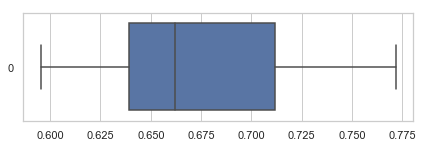

In [161]:
plt.figure(figsize=(7,2))
sns.boxplot(data=scores, orient='h')
plt.show()

### Train Logistic Regression using sklearn

#### Train model

In [162]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

#### Prediction

In [163]:
y_train_pred = model.predict(X_train)
prob_train_pred = model.predict_proba(X_train)

y_test_pred = model.predict(X_test)
prob_test_pred = model.predict_proba(X_test)

#### Model Interpretation: intercept and coefficients 

In [164]:
model.intercept_

array([1.06659474])

In [165]:
model.coef_

array([[-0.76397383, -0.31502468,  0.33648495, -0.51362539,  0.20155908,
        -0.5455573 , -0.6118189 ,  0.80755287,  1.21357785,  0.60244423,
        -0.12973534,  0.22292575, -1.56533314, -0.24739482, -1.07730105,
        -0.92698117, -0.24855942,  0.59860226, -0.82701093, -0.69217729,
        -0.87153041,  0.17840705,  0.62919566, -0.70602713, -0.61076043,
        -0.73530502, -0.55968073, -1.21713054,  0.95442432,  0.01999508,
         0.93963737, -1.48066416,  0.51344459,  0.29855007,  0.23492231,
         0.3336996 ,  0.632197  ,  0.31051846,  0.8544951 ,  0.05883474,
         0.25995997,  0.5126122 , -0.24838652,  0.4147692 ,  1.37627725,
        -0.09430374,  1.0929904 ]])

In [166]:
feature_names = X.columns.values
coefficient_list = list(model.coef_[0])
feature_coefficient = [(feature, coefficient) for feature, coefficient in zip(feature_names, coefficient_list) ]
feature_coefficient

[('LBXRBCSI', -0.7639738303821182),
 ('BPXDI2', -0.3150246820318483),
 ('BPXML1', 0.3364849543847618),
 ('DMDHHSIZ', -0.5136253884552704),
 ('LBDSIRSI', 0.2015590819357731),
 ('BPXSY1', -0.5455573046607363),
 ('LBDNENO', -0.6118188991932838),
 ('LBXSAPSI', 0.8075528739121479),
 ('LBXSLDSI', 1.2135778456957722),
 ('LBDMONO', 0.6024442320742404),
 ('LBXSCR', -0.12973533564716044),
 ('BPXDI1', 0.22292575217431224),
 ('LBDLYMNO', -1.565333143397396),
 ('BPXDI3', -0.24739481861947038),
 ('LBDTCSI', -1.0773010478957499),
 ('BMXHT', -0.9269811728739601),
 ('LBXHGB', -0.24855942258154612),
 ('BPXPLS', 0.5986022592537735),
 ('LBXSBU', -0.8270109344675364),
 ('LBDSTBSI', -0.6921772947697928),
 ('LBXSCLSI', -0.8715304082422688),
 ('LBDSGBSI', 0.17840705104876398),
 ('LBDBANO', 0.6291956592683214),
 ('LBXSTP', -0.7060271298329585),
 ('BMXLEG', -0.6107604324515127),
 ('LBXMC', -0.7353050153293543),
 ('LBDHDD', -0.5596807272342708),
 ('LBDSALSI', -1.2171305413751046),
 ('LBXSGL', 0.9544243233265581)

In [167]:
coefficient_list = np.abs(list(model.coef_[0]))
feature_importance = pd.DataFrame()
feature_importance['FeatureName'] = feature_names
feature_importance['Coef'] = model.coef_[0]
feature_importance['Abs_Coef'] = coefficient_list

feature_importance.sort_values(['Abs_Coef'],ascending = False)

,FeatureName,Coef,Abs_Coef
12,LBDLYMNO,-1.565333,1.565333
31,LBXLYPCT,-1.480664,1.480664
44,BMXARML,1.376277,1.376277
27,LBDSALSI,-1.217131,1.217131
8,LBXSLDSI,1.213578,1.213578
46,RIDAGEYR,1.092990,1.092990
14,LBDTCSI,-1.077301,1.077301
28,LBXSGL,0.954424,0.954424
30,LBXSUA,0.939637,0.939637
15,BMXHT,-0.926981,0.926981


#### Summary table

In [168]:
def LogisticSummaryTable(classifier, X):
    feature_name = X.columns.values
    summary_table = pd.DataFrame(columns = ['FeatureName'], data = feature_name)
    summary_table['Coefficient'] = np.transpose(classifier.coef_)
    summary_table.index = summary_table.index + 1
    summary_table.loc[0] = ['Intercept', classifier.intercept_[0]]
    summary_table = summary_table.sort_index()
    summary_table['Odds_ratio'] = np.exp(summary_table.Coefficient)
    summary_table = summary_table.sort_values('Odds_ratio', ascending = False)
    
    return summary_table

In [169]:
LogisticSummaryTable(model, X_train)

,FeatureName,Coefficient,Odds_ratio
45,BMXARML,1.376277,3.960132
9,LBXSLDSI,1.213578,3.365504
47,RIDAGEYR,1.092990,2.983182
0,Intercept,1.066595,2.905469
29,LBXSGL,0.954424,2.597175
31,LBXSUA,0.939637,2.559053
39,BPACSZ,0.854495,2.350187
8,LBXSAPSI,0.807553,2.242414
37,LBXSTR,0.632197,1.881740
23,LBDBANO,0.629196,1.876101


#### Accuracy

In [170]:
print('Train: ',accuracy_score(y_train, y_train_pred))
print('Test: ', accuracy_score(y_test, y_test_pred))

Train:  0.7188612099644128
Test:  0.7251184834123223


#### Confusion Matrix & Classification Report

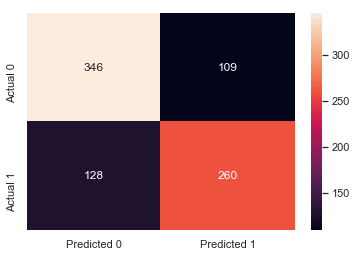

In [171]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_train_pred)
cm_df = pd.DataFrame(cm)
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index = {0: 'Actual 0', 1: 'Actual 1'})
sns.heatmap(cm_df, annot = True, fmt="d")
plt.show()

In [172]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       455
           1       0.70      0.67      0.69       388

    accuracy                           0.72       843
   macro avg       0.72      0.72      0.72       843
weighted avg       0.72      0.72      0.72       843



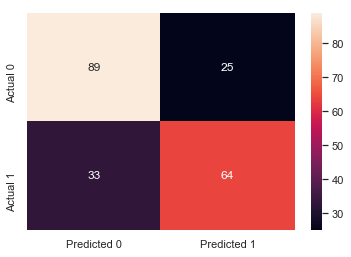

In [173]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm)
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index = {0: 'Actual 0', 1: 'Actual 1'})
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

In [174]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75       114
           1       0.72      0.66      0.69        97

    accuracy                           0.73       211
   macro avg       0.72      0.72      0.72       211
weighted avg       0.72      0.73      0.72       211



#### ROC AUC Score

In [175]:
print(roc_auc_score(y_train, prob_train_pred[:,1]))
print(roc_auc_score(y_test, prob_test_pred[:,1]))

0.7986461991616631
0.7912823295351781


In [176]:
print(roc_auc_score(y_train, y_train_pred))
print(roc_auc_score(y_test, y_test_pred))

0.7152713266115327
0.7202477844094772


#### ROC Curve

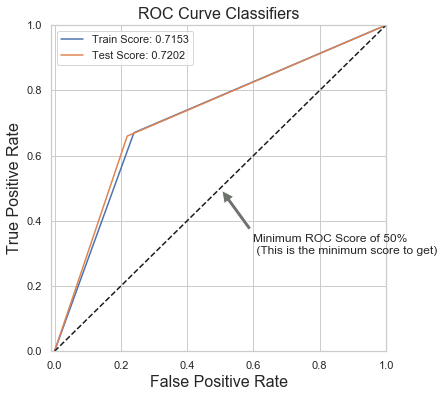

In [177]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, threshold = roc_curve(y_test, y_test_pred)

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, y_train_pred)))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, y_test_pred)))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()

#### Precision-Recall curve

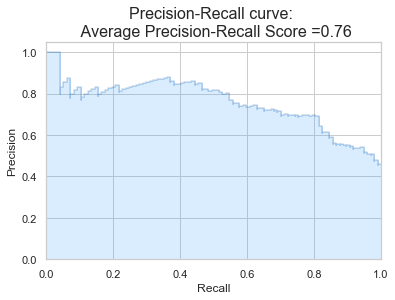

In [178]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_test_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)
plt.show()

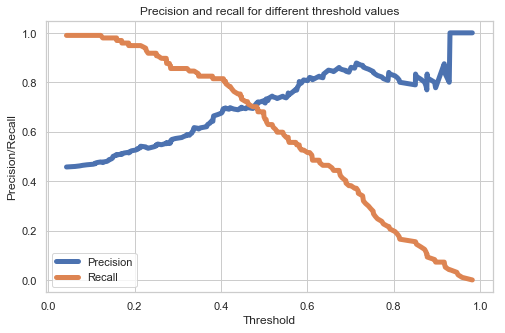

In [179]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Text(0.5,1,'Precision-Recall curve: \n Average Precision-Recall Score =0.76')

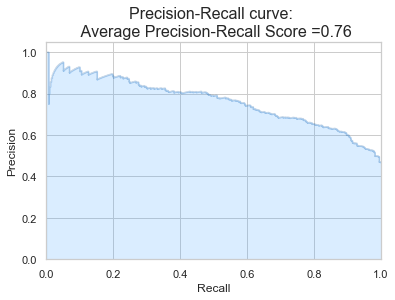

In [180]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = prob_train_pred[:,1]
precision, recall, threshold = precision_recall_curve(y_train,y_score)
average_precision = average_precision_score(y_train, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

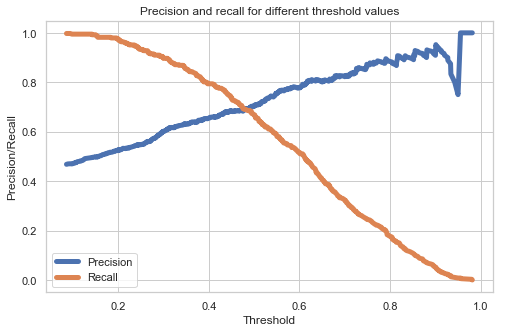

In [181]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

#### Summary

In [182]:
def ModelEvaluation(model,X_train,y_train,X_test,y_test,name):
    print('Model Evaluation of ' + name)

    print('-----------------------------------------------------------')
    print('Train set')
    print('Accuracy: ', accuracy_score(y_train, y_train_pred))
    print('ROC AUC Score: ', roc_auc_score(y_train, y_train_pred))
    cm_df = pd.DataFrame(confusion_matrix(y_train,y_train_pred), index=model.classes_,columns=model.classes_)
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_train, y_train_pred))
    
    print('-----------------------------------------------------------')
    print('Test set')
    print('Accuracy: ', accuracy_score(y_test, y_test_pred))
    print('ROC AUC Score: ', roc_auc_score(y_test, y_test_pred))
    cm_df = pd.DataFrame(confusion_matrix(y_test,y_test_pred), index=model.classes_,columns=model.classes_)
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_test, y_test_pred))
    
ModelEvaluation(model,X_train,y_train,X_test,y_test,'Logistic Regression')

Model Evaluation of Logistic Regression
-----------------------------------------------------------
Train set
Accuracy:  0.7188612099644128
ROC AUC Score:  0.7152713266115327
Confusion matrix
Predicted    0    1
Actual             
0          346  109
1          128  260
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       455
           1       0.70      0.67      0.69       388

    accuracy                           0.72       843
   macro avg       0.72      0.72      0.72       843
weighted avg       0.72      0.72      0.72       843

-----------------------------------------------------------
Test set
Accuracy:  0.7251184834123223
ROC AUC Score:  0.7202477844094772
Confusion matrix
Predicted   0   1
Actual           
0          89  25
1          33  64
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       114
           1       0.72      0.66      0.69        97

    accuracy  

### Tuning hyper-parameters

#### Apply Grid search and KFold Cross Validation

In [183]:
# Specify parameters
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
params = [
    {'C': c_values, 'penalty': ['l1'], 'solver' : ['liblinear'], 'multi_class' : ['ovr']},
    {'C': c_values, 'penalty': ['l2'], 'solver' : ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class' : ['ovr']}
]

grid_search = GridSearchCV(LogisticRegression(), params, cv = 10, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits
[CV] C=0.001, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=0.001, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=0.001, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=0.001, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=0.001, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=0.001, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l1, solver=liblinear ..........
[CV]  C=0.001, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l1, solver=libli

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  C=0.1, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.1, multi_class=ovr, penalty=l1, solver=liblinear ............
[CV]  C=0.1, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=1, multi_class=ovr, penalty=l1, solver=liblinear ..............
[CV]  C=1, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=1, multi_class=ovr, penalty=l1, solver=liblinear ..............
[CV]  C=1, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=1, multi_class=ovr, penalty=l1, solver=liblinear ..............
[CV]  C=1, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=1, multi_class=ovr, penalty=l1, solver=liblinear ..............
[CV]  C=1, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=1, multi_class=ovr, penalty=l1, solver=liblinear ..............
[CV]  C=1, multi_class=ovr, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=1, multi_class=ovr, penalty=l1, solver=liblinear ..........

[CV]  C=0.001, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l2, solver=newton-cg ..........
[CV]  C=0.001, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l2, solver=newton-cg ..........
[CV]  C=0.001, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l2, solver=newton-cg ..........
[CV]  C=0.001, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l2, solver=lbfgs ..............
[CV]  C=0.001, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l2, solver=lbfgs ..............
[CV]  C=0.001, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l2, solver=lbfgs ..............
[CV]  C=0.001, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.001, multi_class=ovr, penalty=l2, solver=lbfg

[CV]  C=0.1, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.1, multi_class=ovr, penalty=l2, solver=newton-cg ............
[CV]  C=0.1, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.1, multi_class=ovr, penalty=l2, solver=newton-cg ............
[CV]  C=0.1, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.1, multi_class=ovr, penalty=l2, solver=newton-cg ............
[CV]  C=0.1, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.1, multi_class=ovr, penalty=l2, solver=newton-cg ............
[CV]  C=0.1, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.1, multi_class=ovr, penalty=l2, solver=lbfgs ................
[CV] . C=0.1, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.1, multi_class=ovr, penalty=l2, solver=lbfgs ................
[CV] . C=0.1, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.1, multi_class=ovr, penalty=l2, solver=lbfgs ........

[CV]  C=10, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=10, multi_class=ovr, penalty=l2, solver=newton-cg .............
[CV]  C=10, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=10, multi_class=ovr, penalty=l2, solver=newton-cg .............
[CV]  C=10, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=10, multi_class=ovr, penalty=l2, solver=lbfgs .................
[CV] .. C=10, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.1s
[CV] C=10, multi_class=ovr, penalty=l2, solver=lbfgs .................
[CV] .. C=10, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.1s
[CV] C=10, multi_class=ovr, penalty=l2, solver=lbfgs .................
[CV] .. C=10, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.1s
[CV] C=10, multi_class=ovr, penalty=l2, solver=lbfgs .................
[CV] .. C=10, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.1s
[CV] C=10, multi_class=ovr, penalty=l2, solver=lbfgs .................


[CV]  C=1000, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=1000, multi_class=ovr, penalty=l2, solver=newton-cg ...........
[CV]  C=1000, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=1000, multi_class=ovr, penalty=l2, solver=newton-cg ...........
[CV]  C=1000, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=1000, multi_class=ovr, penalty=l2, solver=newton-cg ...........
[CV]  C=1000, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=1000, multi_class=ovr, penalty=l2, solver=newton-cg ...........
[CV]  C=1000, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=1000, multi_class=ovr, penalty=l2, solver=newton-cg ...........
[CV]  C=1000, multi_class=ovr, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=1000, multi_class=ovr, penalty=l2, solver=lbfgs ...............
[CV]  C=1000, multi_class=ovr, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=1000, multi_class=ovr, penalty=l2, solver=lbfg

[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:   19.4s finished


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'multi_class': ['ovr'], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'multi_class': ['ovr'], 'penalty': ['l2'],
                          'solver': ['liblinear', 'newton-cg', 'lbfgs']}],
             verbose=2)

#### Best model

In [184]:
grid_search.best_params_

{'C': 1, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}

In [185]:
best_model = grid_search.best_estimator_
best_model

LogisticRegression(C=1, multi_class='ovr', penalty='l1', solver='liblinear')

#### Rerun with the best model

In [105]:
scores = cross_val_score(model, X_train, y_train, cv=10)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std() * 2))

Accuracy: 68.68% (+/- 8.94%)


In [106]:
scores = cross_val_score(best_model, X_train, y_train, cv=10)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std() * 2))

Accuracy: 69.04% (+/- 8.48%)


In [107]:
scores

array([0.64705882, 0.72941176, 0.67058824, 0.66666667, 0.77380952,
       0.66666667, 0.67857143, 0.67857143, 0.64285714, 0.75      ])

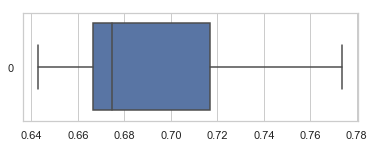

In [108]:
plt.figure(figsize=(6,2))
sns.boxplot(data=scores, orient='h')
plt.show()

In [109]:
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
prob_train_pred = best_model.predict_proba(X_train)

y_test_pred = best_model.predict(X_test)
prob_test_pred = best_model.predict_proba(X_test)

In [110]:
LogisticSummaryTable(best_model, X_train)

,FeatureName,Coefficient,Odds_ratio
31,BMXARML,1.436698,4.206783
8,LBXNEPCT,1.295126,3.651455
51,LBXSLDSI,1.265503,3.544875
53,LBDSGLSI,1.068696,2.911580
2,LBXMOPCT,1.040599,2.830913
1,RIDAGEYR,0.984978,2.677752
38,LBDSUASI,0.974064,2.648687
29,PHAFSTHR,0.908625,2.480909
59,LBXSAPSI,0.844283,2.326310
24,BPACSZ,0.820641,2.271956


In [111]:
ModelEvaluation(best_model,X_train,y_train,X_test,y_test,'LogisticRegression')

Model Evaluation of LogisticRegression
-----------------------------------------------------------
Train set
Accuracy:  0.7212336892052195
ROC AUC Score:  0.7174691288093349
Confusion matrix
Predicted    0    1
Actual             
0          348  107
1          128  260
              precision    recall  f1-score   support

           0       0.73      0.76      0.75       455
           1       0.71      0.67      0.69       388

    accuracy                           0.72       843
   macro avg       0.72      0.72      0.72       843
weighted avg       0.72      0.72      0.72       843

-----------------------------------------------------------
Test set
Accuracy:  0.7440758293838863
ROC AUC Score:  0.7400976668475312
Confusion matrix
Predicted   0   1
Actual           
0          90  24
1          30  67
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       114
           1       0.74      0.69      0.71        97

    accuracy   

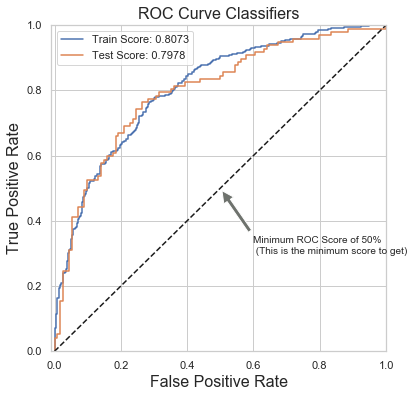

In [112]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, prob_train_pred[:,1])
fpr_test, tpr_test, threshold = roc_curve(y_test, prob_test_pred[:,1])

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, prob_train_pred[:,1])))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, prob_test_pred[:,1])))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()

In [113]:
y_score = best_model.decision_function(X_test)
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)

precision_recall_df = pd.DataFrame([precision[0:len(threshold)],recall[0:len(threshold)],threshold]).T
precision_recall_df.columns = ['precision','recall','threshold']
precision_recall_df.head(6)

,precision,recall,threshold
0,0.459716,1.000000,-3.083877
1,0.457143,0.989691,-3.015597
2,0.459330,0.989691,-2.712189
3,0.461538,0.989691,-2.592574
4,0.463768,0.989691,-2.451932
5,0.466019,0.989691,-2.423306


Text(0.5,1,'Precision-Recall curve: \n Average Precision-Recall Score =0.76')

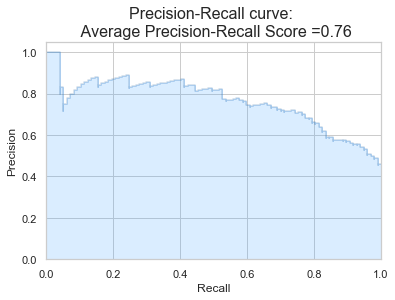

In [114]:
plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

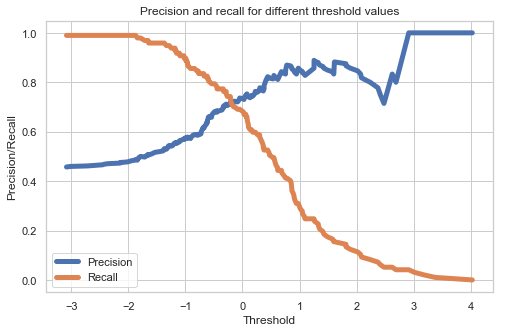

In [115]:
sns.set(style = 'whitegrid',context = 'notebook')
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()